In [1]:
#Author: ML Tlachac
#Paper: Depression Screening from Text Message Reply Latency
#year: 2020
#github.com/mltlachac/EMBC2020

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, NMF

In [2]:
df = pd.read_csv("cleanedLatencyTexts14.csv")
df = df.drop(columns = ["mean"])
df.head()

,id,contacts,responses,min,quant10,quant25,quant50,quant75,quant90,max,score
0,m2349,2,2,106,181.5,294.75,483.5,672.25,785.5,861,21
1,m5227,2,2,110,213.3,368.25,626.5,884.75,1039.7,1143,18
2,m8762,2,2,49,258.3,572.25,1095.5,1618.75,1932.7,2142,15
3,m7778,2,2,110,213.3,368.25,626.5,884.75,1039.7,1143,17
4,m9301,1,2,597,869.1,1277.25,1957.5,2637.75,3045.9,3318,17


In [28]:
#df0.head()
#must rerun data loading
features = 9

data = df
#print(data)
data[data.columns[-1]] = np.where(data[data.columns[-1]] >= 10, 1, 0)
#print(data)
featureSubset = data[data.columns[1:-1]]
fs100 = data[data.columns[1:]]
target = data[data.columns[-1]]
min_max_scaler = preprocessing.MinMaxScaler()                   #NEED TO SCALE BEFORE FEATURE SELECTION!
np_scaled = min_max_scaler.fit_transform(featureSubset)
featureSubset = pd.DataFrame(np_scaled)
fdfs = []
featureSubset2 = SelectKBest(chi2, k=features).fit_transform(featureSubset, target)
selector = SelectKBest(chi2, k=features).fit(featureSubset, target)
indexes = list(selector.get_support(indices=True))
featureSubset3=pd.DataFrame(featureSubset2).assign(target = target)
featureSubset3.head()

,0,1,2,3,4,5,6,7,8,target
0,0.047619,0.0,0.018577,0.017772,0.013843,0.011492,0.010701,0.010437,0.009951,1
1,0.047619,0.0,0.019278,0.020908,0.017316,0.014905,0.014094,0.013823,0.013218,1
2,0.047619,0.0,0.008587,0.025346,0.026954,0.026098,0.025813,0.025718,0.024790,1
3,0.047619,0.0,0.019278,0.020908,0.017316,0.014905,0.014094,0.013823,0.013218,1
4,0.000000,0.0,0.104627,0.085586,0.060262,0.046672,0.042083,0.040546,0.038413,1


In [29]:
columnNames = list(fs100[1:-1].columns)
names = []
for i in indexes:
    names.append(columnNames[i])
fs100[names].head()

,contacts,responses,min,quant10,quant25,quant50,quant75,quant90,max
0,2,2,106,181.5,294.75,483.5,672.25,785.5,861
1,2,2,110,213.3,368.25,626.5,884.75,1039.7,1143
2,2,2,49,258.3,572.25,1095.5,1618.75,1932.7,2142
3,2,2,110,213.3,368.25,626.5,884.75,1039.7,1143
4,1,2,597,869.1,1277.25,1957.5,2637.75,3045.9,3318


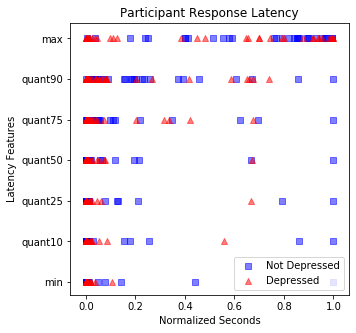

In [30]:
names.append("target")
featureSubset3.columns = names

f1 = featureSubset3[featureSubset3.target == 1] #1 is depressed
f0 = featureSubset3[featureSubset3.target == 0] #0 is not depressed

array1 = []
for name in names:
    namelist = []
    for i in range(0, f1.shape[0]):
        namelist.append(name)
    array1.append(namelist)
    
array0 = []
for name in names:
    namelist = []
    for i in range(0, f0.shape[0]):
        namelist.append(name)
    array0.append(namelist)
    
plt.figure(figsize = (5,5))
for i in range(2, len(names[:-1])):  #change these numbers to add or remove features
    plt.scatter(f0[names[i]], array0[i], color = 'b', alpha = 0.5, label = "Not Depressed", marker = 's')

    plt.scatter(f1[names[i]], array1[i], color = 'r', alpha = 0.5, label = "Depressed", marker = '^')
    #plt.scatter(array0[i], f0[names[i]], color = 'b', alpha = 0.5, label = "Not Depressed", marker = 's')
    if i == 2:
        plt.legend(loc='lower right')
#plt.xticks(names[:-1], rotation='vertical')
plt.ylabel("Latency Features")
plt.xlabel("Normalized Seconds")
plt.title("Participant Response Latency")
#plt.savefig("latencyFeaturesPerParticipant.eps", bbox_inches = "tight")
#plt.savefig("latencyFeaturesPerParticipant.pdf", bbox_inches = "tight")
plt.show()

In [31]:
featureSubset3.corr().style.background_gradient(cmap='Blues')

,contacts,responses,min,quant10,quant25,quant50,quant75,quant90,max,target
contacts,1,0.741457,-0.186413,-0.211225,-0.197845,-0.2029,-0.218457,-0.137705,0.529252,-0.0889248
responses,0.741457,1,-0.147758,-0.186127,-0.181255,-0.192822,-0.241561,-0.267007,0.51195,-0.122633
min,-0.186413,-0.147758,1,0.724407,0.559242,0.48194,0.354129,0.20432,-0.105255,-0.187261
quant10,-0.211225,-0.186127,0.724407,1,0.975824,0.94743,0.766342,0.511612,0.0229021,-0.172188
quant25,-0.197845,-0.181255,0.559242,0.975824,1,0.991124,0.828347,0.567173,0.0644195,-0.15509
quant50,-0.2029,-0.192822,0.48194,0.94743,0.991124,1,0.870633,0.615197,0.0767488,-0.148585
quant75,-0.218457,-0.241561,0.354129,0.766342,0.828347,0.870633,1,0.834082,0.155198,-0.137419
quant90,-0.137705,-0.267007,0.20432,0.511612,0.567173,0.615197,0.834082,1,0.322241,-0.164317
max,0.529252,0.51195,-0.105255,0.0229021,0.0644195,0.0767488,0.155198,0.322241,1,-0.27694
target,-0.0889248,-0.122633,-0.187261,-0.172188,-0.15509,-0.148585,-0.137419,-0.164317,-0.27694,1


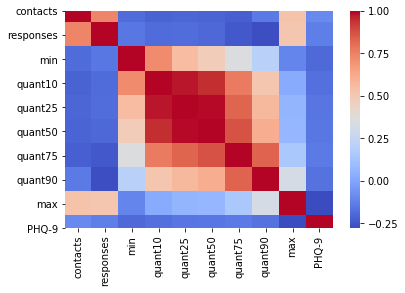

In [69]:
import seaborn as sns

del names[-1]
names.append("PHQ-9")
featureSubset3.columns = names
sns.heatmap(featureSubset3.corr(), cmap ='coolwarm')
plt.savefig("latencyCorrelation3.png", bbox_inches = "tight")
#plt.savefig("latencyCorrelation.eps", bbox_inches = "tight")
#corr = featureSubset3.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(3).set_properties(**{'font-size': '8pt'})

In [51]:
scoring = ['precision', 'recall', 'f1','accuracy', 'roc_auc']
featureE = "PCA"
split = 10

#namelist = ["Tweets", "Texts"]
namelist = ["Texts"]
#ndayslist = [14, 28, 42, 56, 182, 364, "All"]
ndayslist = [14]


for name in namelist:
    for ndays in ndayslist:
        df = pd.read_csv("fixedLatencyTexts14cleaned.csv")
        df = df.drop(columns = ["mean"])
        print("preprocessed" + name + str(ndays) + "daysCleaned")
        
        cnames = df.columns

        df0 = pd.DataFrame()
        for c in cnames:
            df0[c] = df[c].fillna(0)

        data = df0
        nFeatureList = [9]#list(np.arange(0,10,1)) #change for below cells
        featureDF = []
        data[data.columns[-1]] = np.where(data[data.columns[-1]] >= split, 1, 0)
        
        featureSubset = data[data.columns[1:-1]]
        target = data[data.columns[-1]]
        min_max_scaler = preprocessing.MinMaxScaler()                   #NEED TO SCALE BEFORE FEATURE SELECTION!
        np_scaled = min_max_scaler.fit_transform(featureSubset)
        featureSubset = pd.DataFrame(np_scaled)
        featureSubset2 = featureSubset #SelectKBest(chi2, k=10).fit_transform(featureSubset, target) #or feature subset
        for numberOfFeatures in nFeatureList:
            pca = PCA(n_components=numberOfFeatures)
            pca.fit(featureSubset2)
            X_pca = pca.transform(featureSubset2)
            pcaDF = pd.DataFrame(X_pca)#pca.components_.transpose())
            pcaDF = pcaDF.assign(target = target)
            
            var = pca.explained_variance_ratio_
            
            featureDF.append(pcaDF)
            
            #added after
            #print(pcaDF.columns)
            #coefDF = pd.DataFrame(pca.components_,columns=pcaDF.columns)

preprocessedTexts14daysCleaned


In [43]:
coefDF.columns = names[:-1]
coefDF = coefDF.transpose()
coefDF.columns = ["PC1", "PC2","PC3", "PC4","PC5", "PC6","PC7", "PC8", "PC9"]

In [47]:
coefDF.round(decimals=4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
contacts,0.2641,0.2517,0.0055,0.0973,0.1169,0.1186,0.1710,0.2808,0.8495
responses,-0.2787,-0.2979,0.1764,0.3674,0.3720,0.3615,0.4166,0.4314,-0.1964
min,0.3723,0.5053,0.2783,0.3618,0.3107,0.2505,-0.0015,-0.4212,-0.2470
quant10,0.5500,0.2253,-0.3113,-0.2103,-0.1111,-0.0341,0.2557,0.5078,-0.4109
quant25,0.4592,-0.4084,0.6629,0.1043,-0.1451,-0.2328,-0.2368,0.2016,-0.0045
quant50,-0.4418,0.6000,0.4622,-0.0505,-0.2329,-0.2556,0.0451,0.3163,-0.0836
quant75,0.0732,-0.1225,0.2137,-0.1907,-0.2348,-0.1440,0.8123,-0.3987,0.0547
quant90,-0.0004,-0.0007,0.1608,-0.2147,-0.5285,0.7989,-0.1025,0.0037,0.0045
max,-0.0018,0.0014,0.2643,-0.7645,0.5738,0.1134,-0.0582,0.0091,-0.0001


[4.23555434e-01 3.70385322e-01 1.01508357e-01 4.96500387e-02
 2.67708578e-02 2.17007630e-02 6.22251597e-03 1.86532834e-04
 2.01791165e-05]


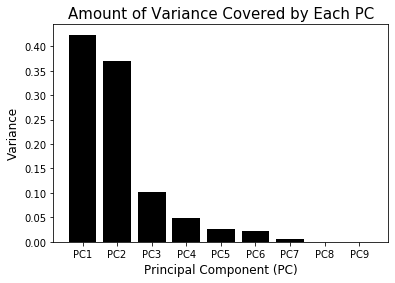

In [62]:
print(var)
plt.bar(["PC1", "PC2","PC3", "PC4","PC5", "PC6","PC7", "PC8", "PC9"], var, color = 'k')
plt.title("Amount of Variance Covered by Each PC", fontsize = 15)
plt.ylabel("Variance", fontsize = 12)
plt.xlabel("Principal Component (PC)", fontsize = 12)
plt.savefig("varPCA.eps", bbox_inches = "tight")
plt.show()
plt.close()

In [68]:
print((var * 100)[0])
print((var * 100)[-2])

42.35554336757241
0.018653283408031664


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

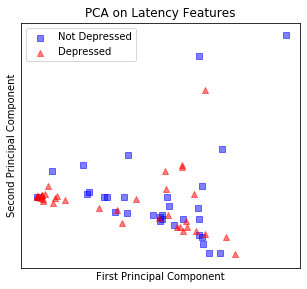

In [49]:
pcaDF = featureDF[2]

f1 = pcaDF[pcaDF.target == 1]
f0 = pcaDF[pcaDF.target == 0]

plt.figure(figsize = (5,4.5))
plt.scatter(f0[0], f0[1], alpha = 0.5, label = "Not Depressed", marker = 's', color = 'b')
plt.scatter(f1[0], f1[1], alpha = 0.5, label = "Depressed", marker = '^', color = 'r')
plt.title("PCA on Latency Features")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("paperPCA2text10.png", bbox_inches = "tight")
plt.savefig("paperPCA2text10.eps", bbox_inches = "tight")
plt.show()
plt.close()